# Time to get your hands dirty! The transient Universe

## Task 
Let's go back to our previous example on the astrophysical transient.
8. Fit the same model from before with the same priors, but this time use nested sampling.
$$
y = b, \quad \text{for } t < t_0
$$

$$
y = b + A \exp[-\alpha (t - t_0)], \quad \text{for } t \geq t_0
$$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used ppf from scipy.stats.uniform, but there are other ways to do it)
An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

9. Another possible model that may explain the data is a Gaussian profile described by:
$$
y = b + A \exp[-(t - t_0)^2/2\sigma_g^2], \quad \text{for } t \geq t_0
$$
Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

10. Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

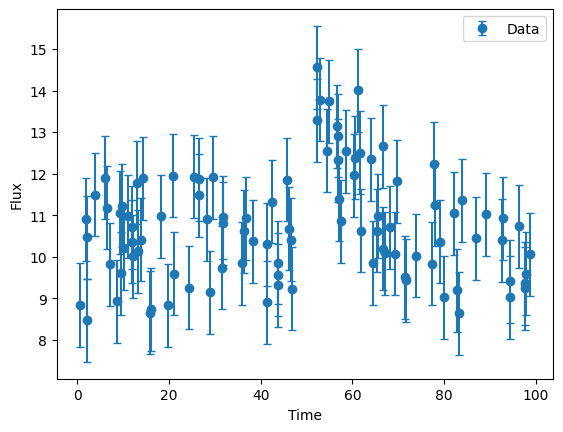

In [23]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load("transient.npy")

time_data, flux, err = data[:,0], data[:,1], data[:,2]

plt.errorbar(time_data, flux, yerr=err, fmt='o', label='Data', capsize=3)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()


/tmp/ipykernel_10859/2359464387.py:8: RuntimeWarning: overflow encountered in exp
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
/tmp/ipykernel_10859/2359464387.py:8: RuntimeWarning: overflow encountered in multiply
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
1820it [00:01, 732.55it/s, bound: 0 | nc: 14 | ncall: 17213 | eff(%): 10.573 | loglstar:   -inf < -276.821 <    inf | logz: -285.579 +/-  0.124 | dlogz: 126.221 >  0.509]   /tmp/ipykernel_10859/2359464387.py:8: RuntimeWarning: overflow encountered in exp
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
/tmp/ipykernel_10859/2359464387.py:8: RuntimeWarning: overflow encountered in multiply
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
/tmp/ipykernel_10859/2359464387.py:8: RuntimeWarning: overflow encountered in exp
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
1902it [00:02, 440.34it/s, bound: 2 | nc: 3 | ncall: 19375 | eff(%):  9.

(<Figure size 970x970 with 16 Axes>,
 array([[<Axes: title={'center': '$C$ = ${10.295}_{-0.237}^{+0.238}$'}>,
         <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$A$'>,
         <Axes: title={'center': '$A$ = ${5.410}_{-2.042}^{+4.394}$'}>,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$\\alpha$'>, <Axes: >,
         <Axes: title={'center': '$\\alpha$ = ${0.122}_{-0.043}^{+0.069}$'}>,
         <Axes: >],
        [<Axes: xlabel='$C$', ylabel='$t_0$'>, <Axes: xlabel='$A$'>,
         <Axes: xlabel='$\\alpha$'>,
         <Axes: title={'center': '$t_0$ = ${49.215}_{-2.252}^{+2.755}$'}, xlabel='$t_0$'>]],
       dtype=object))

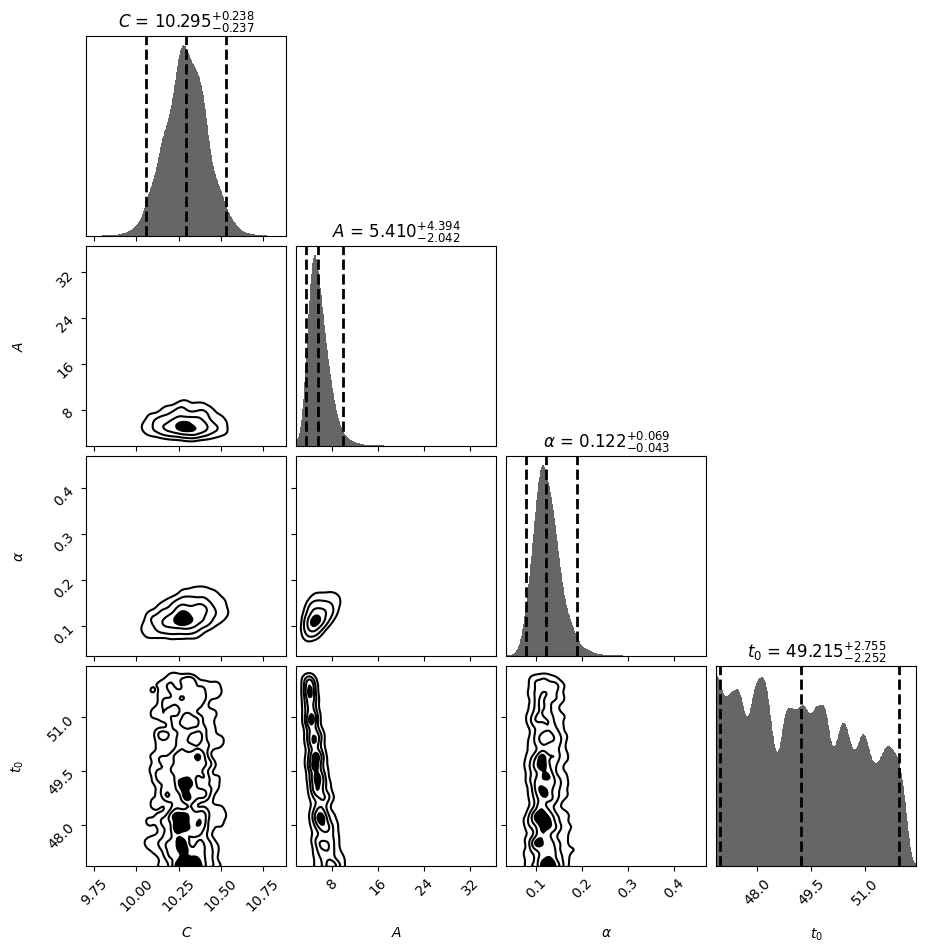

In [24]:
import dynesty
from dynesty import plotting as dyplot

def model (t, theta):
    C, A, alpha, t0 = theta
    return np.where(t < t0,                                     # for t < t0
                    C,                                          #costant
                    C + A * np.exp(- alpha *(t - t0)))          # else , hp function

def loglikelihood(theta):
    model_flux = model(time_data, theta)
    chi2 = np.sum(((flux - model_flux) / err) ** 2)
    logL = -0.5 * chi2 - np.sum(np.log(np.sqrt(2 * np.pi) * err))
    return logL

def prior_transform(u):
    C = 0 + 50 * u[0]                          # Uniform(0, 50)
    A = 0 + 50 * u[1]                          # Uniform(0, 50)
    alpha = np.exp(-5 + 10 * u[2])             # Log-uniform in [e^-5, e^5]
    t0 = 0 + 100 * u[3]                        # Uniform(0, 100)
    return [C, A, alpha, t0]


ndim = 4  #number of parameters

sampler = dynesty.NestedSampler(loglikelihood, prior_transform , ndim)
sampler.run_nested()    
sresult = sampler.results
labels = [r"$C$", r"$A$", r"$\alpha$", r"$t_0$"]
dyplot.cornerplot(sresult, show_titles=True, labels=labels, title_fmt=".3f")

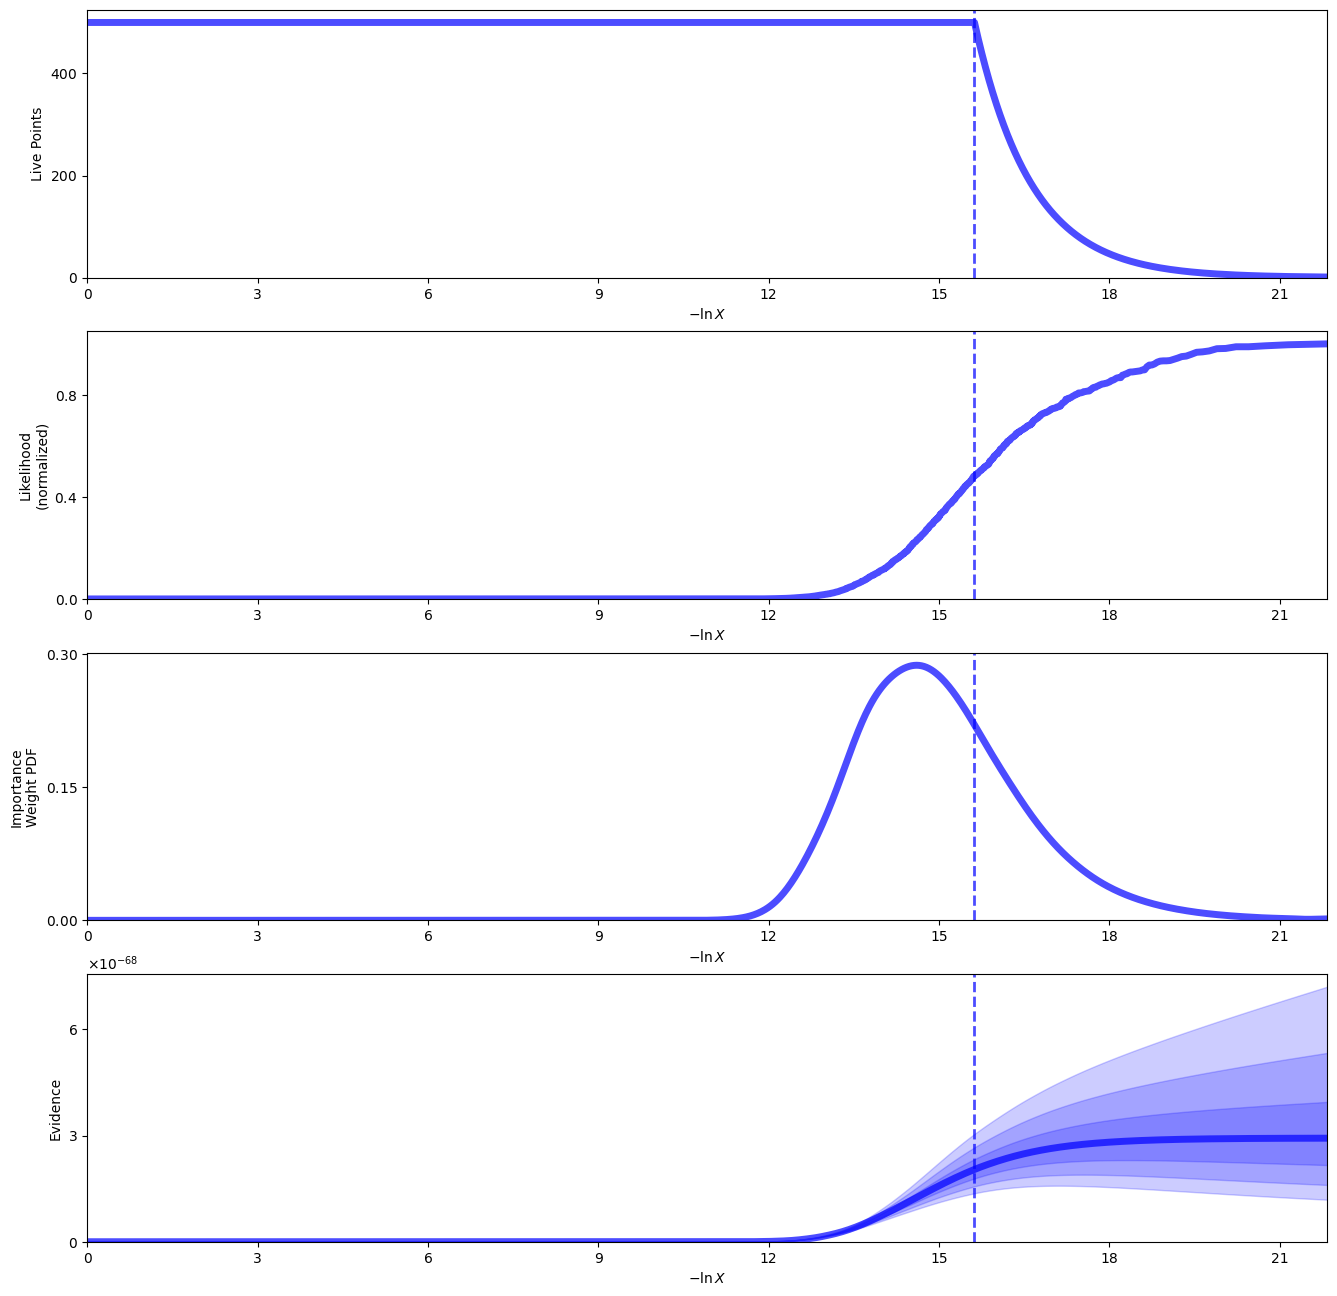

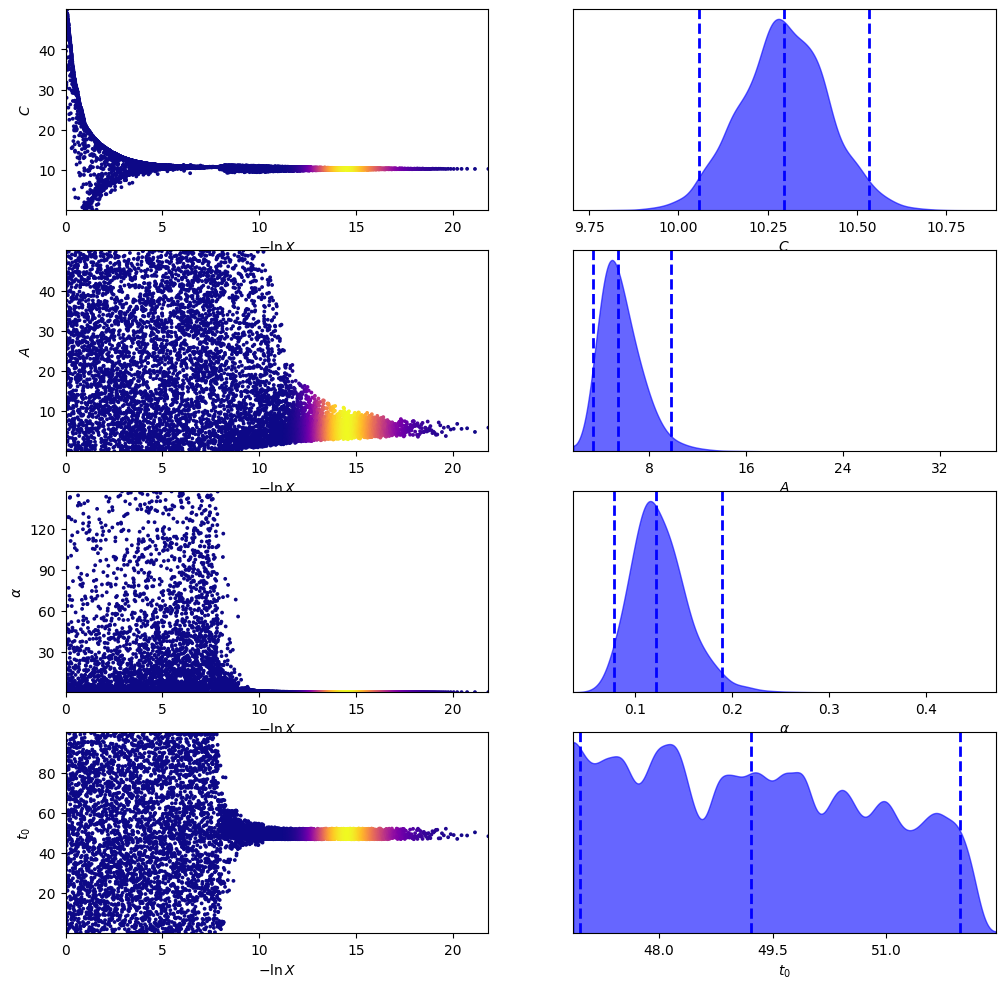

In [25]:
rfig, raxes = dyplot.runplot(sresult)
tfig, taxes = dyplot.traceplot(sresult , labels=labels)

=== Parameters compare ===
Dynesty (MAP):       C=10.280, A=5.868, alpha=0.117, t0=48.364
curve_fit:           C=10.298, A=3.707, alpha=0.117, t0=52.185


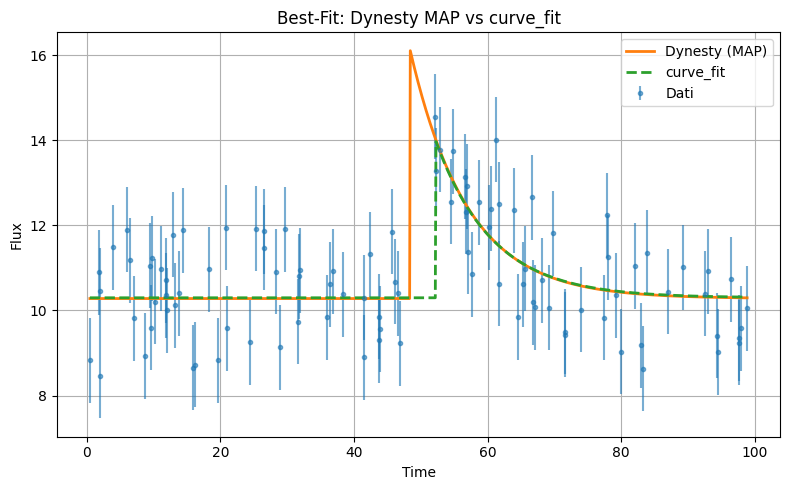

In [26]:
from scipy.optimize import curve_fit

def model_curve_fit(t, C, A, alpha, t0):
    return np.where(t < t0,
                    C,
                    C + A * np.exp(-alpha * (t - t0)))

# initial values for fitting
C0 = np.median(flux)
A0 = np.max(flux) - C0
alpha0 = 0.1
t0_init = time_data[np.argmax(flux)]


# === Dynesty:  MAP Max At Posteriori ===
best_idx = np.argmax(sresult.logl)
pars_map = sresult.samples[best_idx]
C_map, A_map, alpha_map, t0_map = pars_map

# === curve_fit ===
popt, pcov = curve_fit(model_curve_fit, time_data, flux, sigma=err, p0=[C0, A0, alpha0, t0_init])
C_cf, A_cf, alpha_cf, t0_cf = popt

# === Comparison ===
print("=== Parameters compare ===")
print(f"Dynesty (MAP):       C={C_map:.3f}, A={A_map:.3f}, alpha={alpha_map:.3f}, t0={t0_map:.3f}")
print(f"curve_fit:           C={C_cf:.3f}, A={A_cf:.3f}, alpha={alpha_cf:.3f}, t0={t0_cf:.3f}")

# === Plot ===
t_fit = np.linspace(time_data.min(), time_data.max(), 1000)
flux_map = model(t_fit, pars_map)
flux_cf  = model(t_fit, popt)

plt.figure(figsize=(8, 5))
plt.errorbar(time_data, flux, yerr=err, fmt='.', label='Dati', alpha=0.6)
plt.plot(t_fit, flux_map, '-', lw=2, label='Dynesty (MAP)', c='C1')
plt.plot(t_fit, flux_cf, '--', lw=2, label='curve_fit', c='C2')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Best-Fit: Dynesty MAP vs curve_fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


6443it [00:08, 722.82it/s, +500 | bound: 28 | nc: 1 | ncall: 38938 | eff(%): 18.063 | loglstar:   -inf < -144.310 <    inf | logz: -156.468 +/-  0.156 | dlogz:  0.001 >  0.509]


(<Figure size 970x970 with 16 Axes>,
 array([[<Axes: title={'center': '$C$ = ${10.311}_{-0.248}^{+0.235}$'}>,
         <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$A$'>,
         <Axes: title={'center': '$A$ = ${2.724}_{-0.723}^{+0.776}$'}>,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$\\sigma$'>, <Axes: >,
         <Axes: title={'center': '$\\sigma$ = ${5.418}_{-1.585}^{+1.924}$'}>,
         <Axes: >],
        [<Axes: xlabel='$C$', ylabel='$t_0$'>, <Axes: xlabel='$A$'>,
         <Axes: xlabel='$\\sigma$'>,
         <Axes: title={'center': '$t_0$ = ${55.443}_{-1.902}^{+2.086}$'}, xlabel='$t_0$'>]],
       dtype=object))

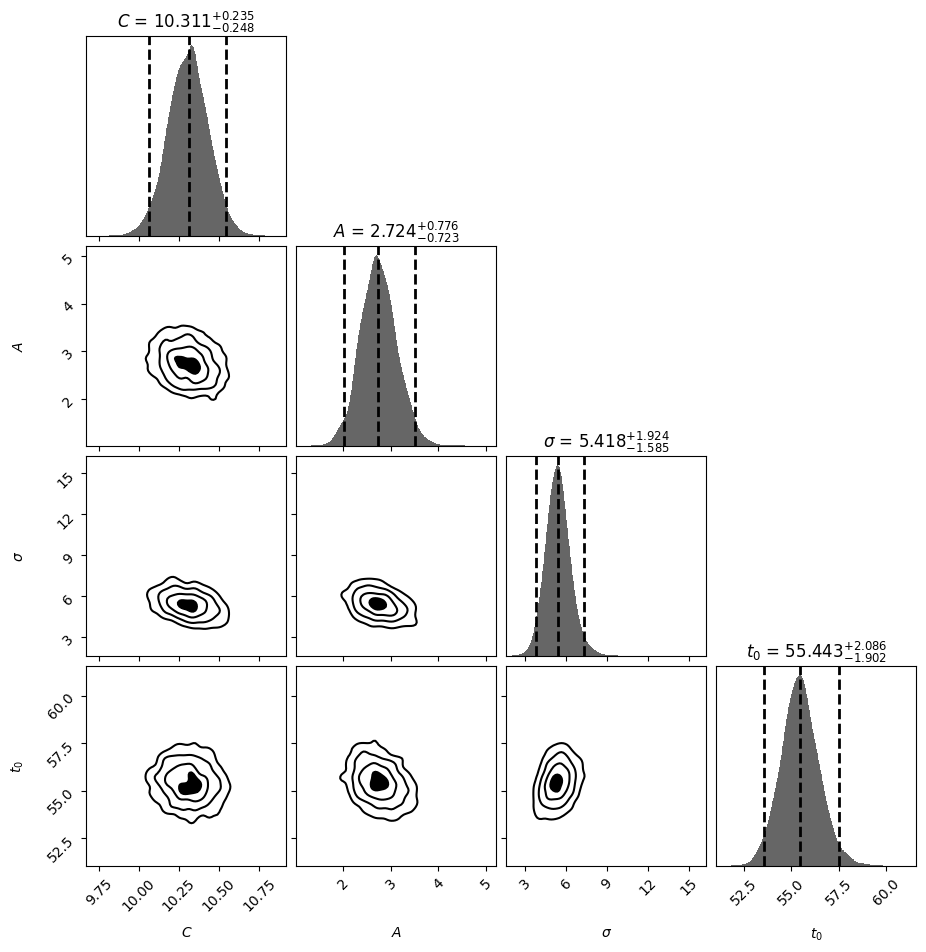

In [27]:
def model2(t, theta):
    C, A, sigma, t0 = theta
    return C + A * np.exp(-(t - t0)**2 / (2 * sigma**2))

def prior_transform2(u):

    ymin = np.min(flux)
    ymax = np.max(flux)
    C = ymin + (ymax - ymin) * u[0]            # Uniform between min and max of the flux
    
    A = 0 + (ymax-ymin) * u[1]                 # Uniform between the "base" and the peak
    
    sigma = 0 + 100*u[2]                        # uniform in 0 - 100

    T = time_data[np.argmax(flux)]
    ymin = T - 30
    ymax = T + 30
    t0 = ymin + (ymax - ymin) * u[3]                # Uniform between T-30 and T + 30

    return [C, A, sigma, t0]

def loglikelihood2(theta):
    C, A, sigma, t0 = theta
    model_flux = model2(time_data, theta)
    chi2 = np.sum(((flux - model_flux) / err) ** 2)
    logL = -0.5 * chi2 - np.sum(np.log(np.sqrt(2 * np.pi) * err))
    return logL

ndim = 4

sampler = dynesty.NestedSampler(loglikelihood2, prior_transform2 , ndim)
sampler.run_nested()
sresult2 = sampler.results
labels = [r"$C$", r"$A$", r"$\sigma$", r"$t_0$"]
dyplot.cornerplot(sresult2, show_titles=True, labels=labels, title_fmt=".3f")


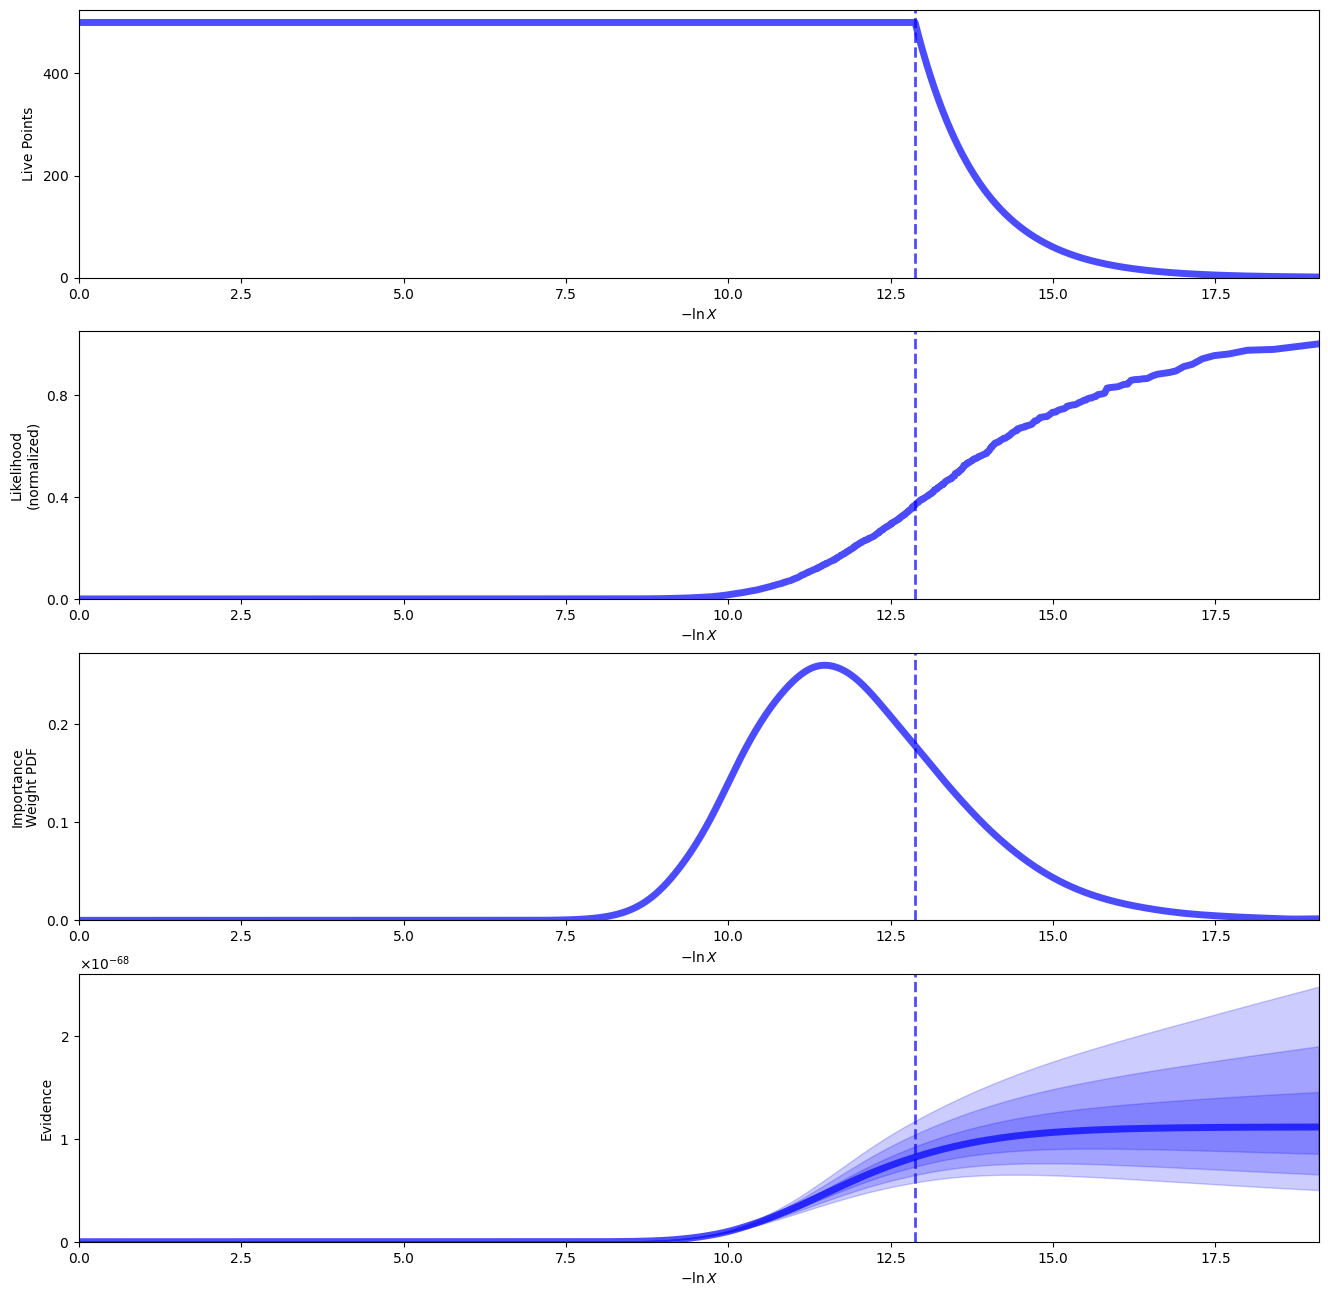

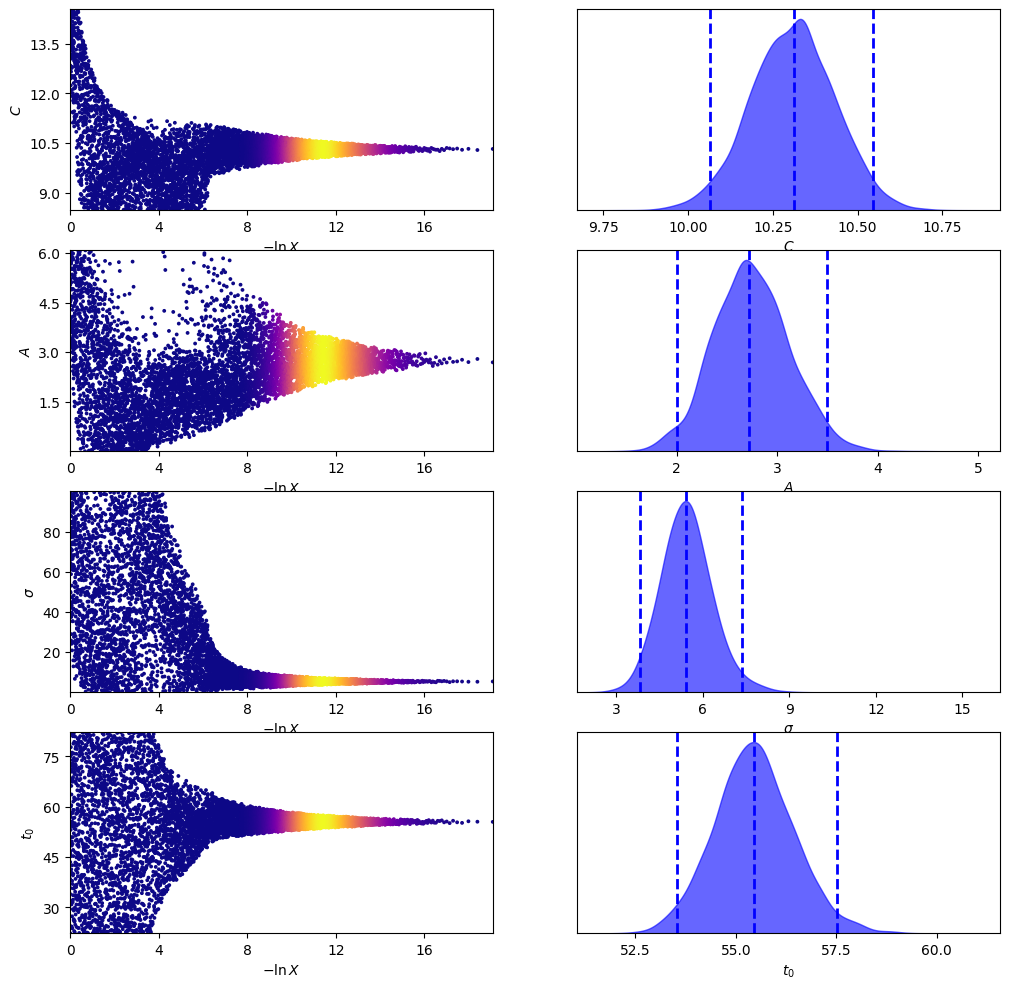

In [28]:
rfig, raxes = dyplot.runplot(sresult2)
tfig, taxes = dyplot.traceplot(sresult2 , labels=labels)

=== Parameters compare ===
Dynesty (MAP):       C=10.319, A=2.694, alpha=5.431, t0=55.495
curve_fit:           C=10.307, A=2.751, alpha=5.370, t0=55.472


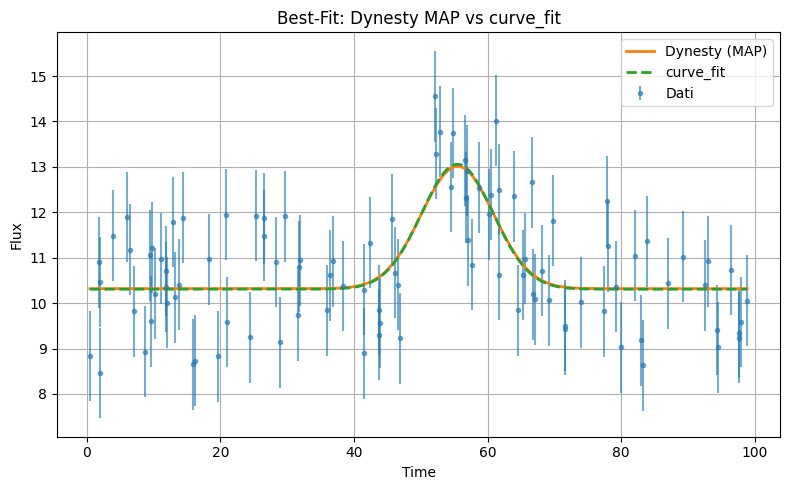

In [30]:
from scipy.optimize import curve_fit

def model_curve_fit2(t, C, A, sigma ,t0):
        return C + A * np.exp(-(t - t0)**2 / (2 * sigma**2))

# initial values for fitting
C0 = np.median(flux)
A0 = np.max(flux) - C0
sigma0 = 5
t0_init = time_data[np.argmax(flux)]


# === Dynesty: MAP : Max At Posteriori ===
best_idx = np.argmax(sresult2.logl)
pars_map = sresult2.samples[best_idx]
C_map, A_map, sigma_map, t0_map = pars_map

# === curve_fit ===
popt, pcov = curve_fit(model_curve_fit2, time_data, flux, sigma=err, p0=[C0, A0, sigma0, t0_init])
C_cf, A_cf, sigma_cf, t0_cf = popt

# === comparison ===
print("=== Parameters compare ===")
print(f"Dynesty (MAP):       C={C_map:.3f}, A={A_map:.3f}, alpha={sigma_map:.3f}, t0={t0_map:.3f}")
print(f"curve_fit:           C={C_cf:.3f}, A={A_cf:.3f}, alpha={sigma_cf:.3f}, t0={t0_cf:.3f}")

# === Plot ===
t_fit = np.linspace(time_data.min(), time_data.max(), 1000)
flux_map = model2(t_fit, pars_map)
flux_cf  = model2(t_fit, popt)

plt.figure(figsize=(8, 5))
plt.errorbar(time_data, flux, yerr=err, fmt='.', label='Dati', alpha=0.6)
plt.plot(t_fit, flux_map, '-', lw=2, label='Dynesty (MAP)', c='C1')
plt.plot(t_fit, flux_cf, '--', lw=2, label='curve_fit', c='C2')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Best-Fit: Dynesty MAP vs curve_fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
#compute the ratio of the evidence

np.exp(sresult.logz[-1])/np.exp(sresult2.logz[-1])


np.float64(2.6251335218786513)